In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.layers.python.layers import initializers
from tensorflow.examples.tutorials.mnist import input_data
from math import sqrt
import numpy as np
from sklearn.manifold import TSNE
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ikryukov\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [3]:
learning_rate = 0.0001
training_epochs = 25
batch_size = 100
display_step = 1
logs_path = './tensorflow_logs/mnist_metrics'
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 28*28 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
margin = 5.0

In [4]:
x_left = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataLeft')
x_right = tf.placeholder(tf.float32, shape=[None, n_input], name='InputDataRight')
label = tf.placeholder(tf.float32, shape=[None, 1], name='LabelData') # 0 if the same, 1 is different
x_image_left = tf.reshape(x_left, [-1,28,28,1], name='image_left')
x_image_right = tf.reshape(x_right, [-1,28,28,1], name='image_right')

In [5]:
def NN(inputs):
    with slim.arg_scope([slim.fully_connected, slim.conv2d], 
                        activation_fn=tf.nn.relu,
                        weights_initializer=initializers.xavier_initializer()
                       ):
        out = slim.conv2d(inputs, 32, [3, 3])
#         print (out.get_shape())
        out = slim.max_pool2d(out, [2, 2], [2, 2])
#         print (out.get_shape())
        out = slim.conv2d(inputs, 64, [3, 3])
#         print (out.get_shape())
        out = slim.max_pool2d(out, [2, 2], [2, 2])
#         print (out.get_shape())
        out = slim.flatten(out)
#         print (out.get_shape())
        out = slim.fully_connected(out, 256)
#         print (out.get_shape())
        out = slim.fully_connected(out, 256)
#         print (out.get_shape())
        out = slim.fully_connected(out, n_classes, activation_fn=None, normalizer_fn=None)
    return out

In [6]:
with tf.name_scope('Model'):
    # Model
    pred_left = NN(x_image_left)
    pred_right = NN(x_image_right)
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    d = tf.reduce_sum(tf.square(pred_left - pred_right), 1)
    d_sqrt = tf.sqrt(d)
    loss = label * tf.square(tf.maximum(0.0, margin - d_sqrt)) + (1 - label) * d
    loss = 0.5 * tf.reduce_mean(loss)
    
with tf.name_scope('AdamOptimizer'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# with tf.name_scope('Accuracy'):
#      # Accuracy
#     correct_pred = tf.equal(tf.argmax(pred_left, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.scalar_summary("loss", loss)
# Create a summary to monitor accuracy tensor
# tf.scalar_summary("accuracy", accuracy)

# Merge all summaries into a single op
merged_summary_op = tf.merge_all_summaries()

In [8]:
# Launch the graph
#with tf.Session() as sess:
sess = tf.Session()
sess.run(init)
# op to write logs to Tensorboard
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.0
    total_batch = int(mnist.train.num_examples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        left_batch_xs, left_batch_ys = mnist.train.next_batch(batch_size)
        right_batch_xs, right_batch_ys = mnist.train.next_batch(batch_size)
        labels = np.zeros((batch_size, 1))
        for l in range(batch_size):
            if (left_batch_ys[l] == right_batch_ys[l]).all():
                labels[l, 0] = 0.0
            else:
                labels[l, 0] = 1.0
        # Run optimization op (backprop), cost op (to get loss value)
        # and summary nodes
        _, l, summary = sess.run([optimizer, loss, merged_summary_op],
                                 feed_dict = {
                                              x_left: left_batch_xs, 
                                              x_right: right_batch_xs,
                                              label: labels,
                                             })
        # Write logs at every iteration
        summary_writer.add_summary(summary, epoch * total_batch + i)
        # Compute average loss
        avg_loss += l / total_batch
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "loss =", "{:.9f}".format(l))

print ("Optimization Finished!")

print ("Run the command line:\n" \
      "--> tensorboard --logdir=./tensorflow_logs " \
      "\nThen open http://0.0.0.0:6006/ into your web browser")

Epoch: 0001 loss = 0.931566656
Epoch: 0002 loss = 1.683836102
Epoch: 0003 loss = 1.128052950
Epoch: 0004 loss = 1.439866543
Epoch: 0005 loss = 1.164820552
Epoch: 0006 loss = 1.322959661
Epoch: 0007 loss = 0.946318328
Epoch: 0008 loss = 1.749828577
Epoch: 0009 loss = 1.131158710
Epoch: 0010 loss = 1.227774024
Epoch: 0011 loss = 1.595436811
Epoch: 0012 loss = 1.341512918
Epoch: 0013 loss = 0.718215704
Epoch: 0014 loss = 1.026961565
Epoch: 0015 loss = 1.515710592
Epoch: 0016 loss = 1.041113377
Epoch: 0017 loss = 1.432600021
Epoch: 0018 loss = 1.126014471
Epoch: 0019 loss = 1.132370949
Epoch: 0020 loss = 0.926986516
Epoch: 0021 loss = 1.617517829
Epoch: 0022 loss = 1.710916638
Epoch: 0023 loss = 1.029392242
Epoch: 0024 loss = 1.225380301
Epoch: 0025 loss = 0.926649451
Optimization Finished!
Run the command line:
--> tensorboard --logdir=./tensorflow_logs 
Then open http://0.0.0.0:6006/ into your web browser


In [9]:
# Test model
# Calculate accuracy
test_xs, test_ys = mnist.train.next_batch(3000)
#print ('Final accuracy : %s' % sess.run(accuracy, feed_dict={x: test_xs ,y: test_ys}))

ans = sess.run([pred_left], feed_dict = { x_left: test_xs})


In [10]:
tsneModel = TSNE(n_components=2, random_state=0)
r = tsneModel.fit_transform(ans[0])

In [11]:
#[test_ys[x,:].argmax() for x in range(len(test_ys))]
#test_ys

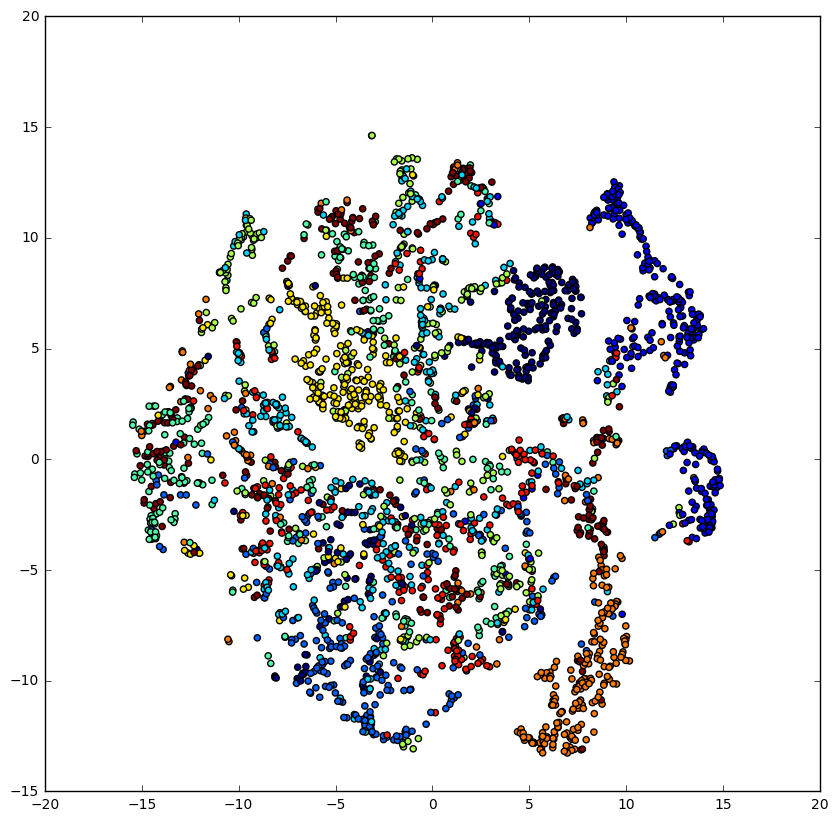

In [12]:
figure(figsize=(10,10))
scatter(r[:,0], r[:,1], c=[test_ys[x,:].argmax() for x in range(len(test_ys))])

In [13]:
test_ys[0,:].argmax()

3